In [1]:
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import csv

In [2]:
month = '201707'

towmetds = Dataset('data/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1.003 and 1.008 kJ/kg.K, thus we can assume it constant at 1.005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

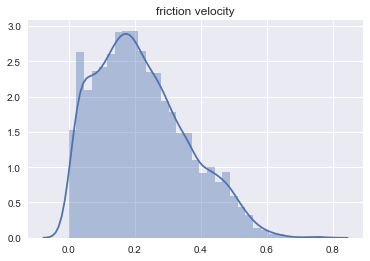

In [115]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

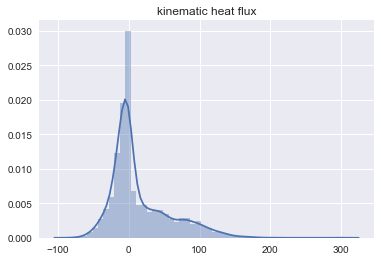

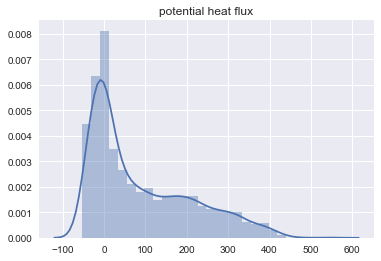

In [116]:
sns.distplot(fluxds['H'][:])
plt.title('kinematic heat flux')
plt.show()

sns.distplot(fluxds['LE'][:])
plt.title('potential heat flux')
plt.show()

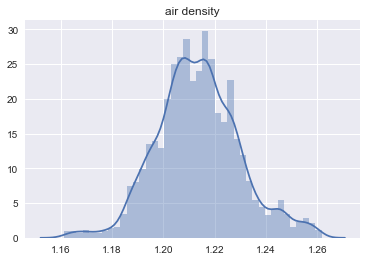

In [117]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

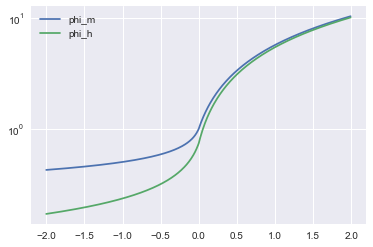

In [118]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

wind and temperature profile

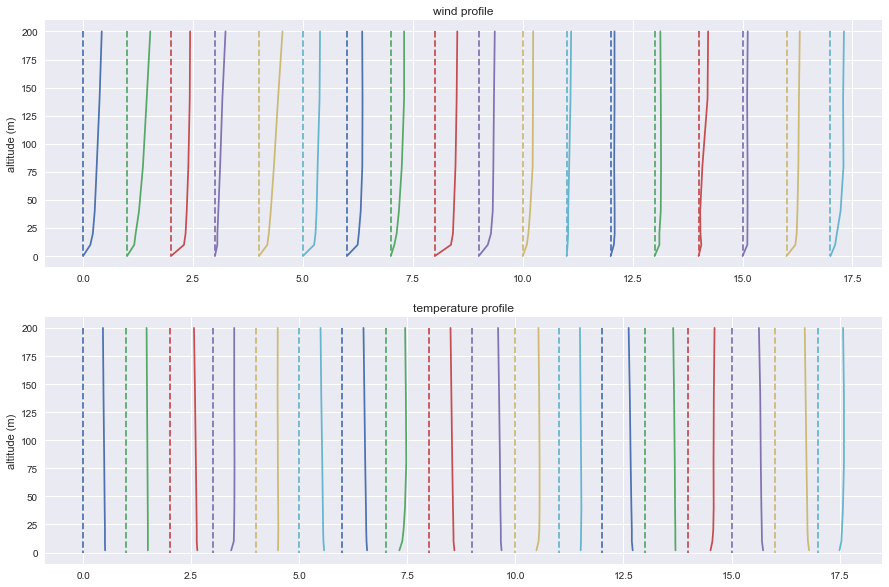

In [119]:
plt.figure(figsize=(15, 5))


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

for i, tt in enumerate(towmetds['time'][::250]):
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 20 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 30 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

wind/temperature profile gradient

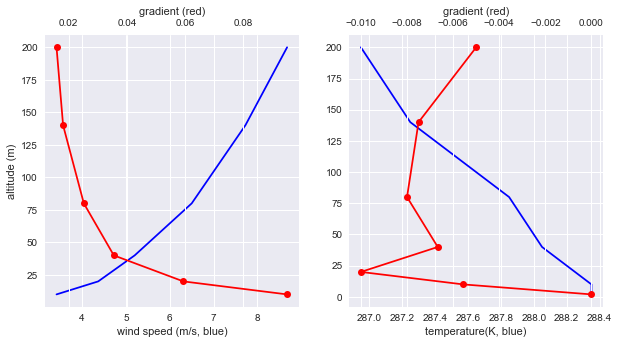

In [120]:
def get_derivative(xs, ys):
    dxdy = []
    for i in range(len(xs)):
        if i == 0:
            d = (ys[i] - ys[i + 1]) / (xs[i] - xs[i + 1])
        elif i == len(xs) - 1:
            d = (ys[i - 1] - ys[i]) / (xs[i - 1] - xs[i])
        else:
            d = (ys[i - 1] - ys[i + 1]) / (xs[i - 1] - xs[i + 1])

        dxdy.append(d)
    
    return dxdy


tt = towmetds['time'][14]

ws = towmetds['F'][tt][:-1]
hw = towmetds['z'][:-1]

ts = towmetds['TA'][tt]
ht = towmetds['z'][:]

dwdz = get_derivative(hw, ws)
dtdz = get_derivative(ht, ts)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax1.set_ylabel('altitude (m)')
ax1.plot(ws, hw, 'x-', c='b')
ax1.set_xlabel('wind speed (m/s, blue)')
ax12 = ax1.twiny()
ax12.plot(dwdz, hw, 'o-', c='r')
ax12.set_xlabel('gradient (red)')

ax2.plot(ts, ht, 'x-', c='b')
ax2.set_xlabel('temperature(K, blue)')
ax22 = ax2.twiny()
ax22.plot(dtdz, ht, 'o-', c='r')
ax22.set_xlabel('gradient (red)')

plt.show()

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [3]:
def process(month):
    try:
        towmetds = Dataset('data/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    for i, tt in enumerate(towmetds['time']):
        surf_temp = 273.15 + meteods['TA002'][tt]
        air_dens = 100 * meteods['P0'][tt] / (287.058 * surf_temp)

        # following hogstrom 1988, correction accounting for turbulent latent heat flux
        virtual_potential_temperature_flux = -(fluxds['H'][tt] / (1.005 * air_dens)) * (
            1 + 0.07 * fluxds['LE'][tt] / fluxds['H'][tt]
        )

        lval = -fluxds['UST'][tt]**3 * surf_temp / (
            0.4 * 9.81 * virtual_potential_temperature_flux
        )

        assert towmetds['z'][-2] == 10 and towmetds['z'][-1]  == 2

        # compute only at lowest layer (10m)
        # because L and H are computed with surface measurements

        # because of no-slip condition, wind at surface is 0
        # no need to account for the roughness length (?, ~0.1m anyways)
        dwdz = towmetds['F'][tt, -2] / 10
        zL_m = towmetds['z'][-2] / lval
        phi_m = dwdz * 0.4 * towmetds['z'][-2] / fluxds['UST'][tt]

        dz = towmetds['z'][-2] - towmetds['z'][-1]
        dt = towmetds['TA'][tt][-2] - towmetds['TA'][tt][-1]
        dtdz = dt / dz
        zL_h = towmetds['z'][-1] / lval
        phi_h = -(
            dtdz * 0.4 * towmetds['z'][-1] * fluxds['UST'][tt] * 1.005 * air_dens
            / fluxds['H'][tt]
        )

        yield {
            'ds': month,
            'year': month[:4],
            'month': month[4:],
            'daym': int(tt / 24),
            'hday': tt % 24,

            'tt': tt,
            'air_dens': air_dens,

            'H': fluxds['H'][tt],
            'LE': fluxds['LE'][tt],

            'ustar': fluxds['UST'][tt],
            'lval': lval,

            'wind': towmetds['F'][tt, 5],
            'dwdz': dwdz,
            'phi_m': phi_m,
            'zL_m': zL_m,

            'surf_tem': surf_temp,
            'dtdz': dtdz,
            'zL_h': zL_h,
            'phi_h': phi_h,

            'IUST': fluxds['IUST'][tt],
            'ILE': fluxds['ILE'][tt],
            'IH': fluxds['IH'][tt],
            'ITA-2': towmetds['ITA'][tt][-2],
            'ITA-1': towmetds['ITA'][tt][-1],
            'IF-2': towmetds['IF'][tt][-2],
            'ITA002': meteods['ITA002'][tt],
            'IP0': meteods['IP0'][tt]
        }

In [4]:
dframe_path = 'data/processed.csv'

if not os.path.exists(dframe_path):
    print('recomputing data (you take a coffee)')
    import findspark
    findspark.init()

    from pyspark import SparkContext, SparkConf
    
    sc = SparkContext(conf=SparkConf().setMaster('local[7]').set('spark.driver.memory', '14g'))
    all_months = set(f[-6-3:-3] for f in os.listdir('data') if f.endswith('.nc'))

    try:
        df_rows = sc.parallelize(all_months, len(all_months)).flatMap(process).collect()
    finally:
        sc.stop()

    df = pd.DataFrame([row.values() for row in df_rows], columns=df_rows[0].keys())
    df.to_csv(dframe_path, index=False)


try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

we first inspect the data from cabauw

In [446]:
measurement_cols = ['air_dens', 'H', 'LE', 'ustar', 'wind', 'surf_tem']

df[measurement_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
air_dens,885168.0,1.246308,0.032742,1.145826,1.223362,1.243266,1.266623,1.432085
H,885168.0,0.396914,36.014806,-459.999756,-18.313057,-5.634647,4.638412,459.924530
LE,885168.0,48.573285,100.322754,-117.415665,-12.331682,10.303337,70.748511,595.862700
ustar,885168.0,0.242782,0.156711,0.000413,0.122761,0.222125,0.335091,1.313813
wind,885168.0,4.226119,2.432713,0.000000,2.430000,3.750000,5.580000,19.219999
surf_tem,885168.0,283.816585,6.810729,253.350001,279.250000,283.750000,288.650000,306.550002


TODO what happened in march 2016 to H measurements?

In [365]:
df[df.ds == 201603].H.describe()

count      4464.000000
mean       1910.507859
std       17186.678281
min       -1552.988037
25%         -49.043514
50%         -14.713778
75%          14.623530
max      287641.125000
Name: H, dtype: float64

for now, we can throw this data away, and check other measurements for suspicious values

In [447]:
df = df[df.ds != 201603]
df[measurement_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
air_dens,885168.0,1.246308,0.032742,1.145826,1.223362,1.243266,1.266623,1.432085
H,885168.0,0.396914,36.014806,-459.999756,-18.313057,-5.634647,4.638412,459.924530
LE,885168.0,48.573285,100.322754,-117.415665,-12.331682,10.303337,70.748511,595.862700
ustar,885168.0,0.242782,0.156711,0.000413,0.122761,0.222125,0.335091,1.313813
wind,885168.0,4.226119,2.432713,0.000000,2.430000,3.750000,5.580000,19.219999
surf_tem,885168.0,283.816585,6.810729,253.350001,279.250000,283.750000,288.650000,306.550002


look good. these are the computed columns

In [449]:
computed_cols = ['phi_m', 'phi_h', 'zL_m', 'zL_h', 'dwdz', 'dtdz', 'lval']
df[computed_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
phi_m,885168.0,8.637848,7.576165e+00,0.000000e+00,5.970971,7.112212,8.661864,6.045813e+02
phi_h,885168.0,0.001361,4.268638e-01,-2.986642e+01,0.000178,0.000370,0.000674,1.584772e+02
zL_m,885168.0,-72690.394196,1.224971e+07,-4.469675e+09,-462.864196,-59.316060,52.624694,1.945478e+07
zL_h,885168.0,-14538.078839,2.449942e+06,-8.939350e+08,-92.572839,-11.863212,10.524939,3.890956e+06
dwdz,885168.0,0.422612,2.432713e-01,0.000000e+00,0.243000,0.375000,0.558000,1.922000e+00
dtdz,885168.0,0.030029,8.585560e-02,-2.877693e-01,-0.012501,0.012501,0.050003,9.125004e-01
lval,885168.0,-0.074642,3.072210e+01,-9.557389e+03,-0.092316,-0.009853,0.016268,3.987525e+03


and finally the index columns with the time of the measurement

In [452]:
index_columns = ['ds', 'year', 'month', 'daym', 'hday', 'tt']
df[index_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
ds,885168.0,200899.033838,486.488379,200101.0,200503.000000,200906.000000,201308.000000,201712.000000
year,885168.0,2008.925004,4.864632,2001.0,2005.000000,2009.000000,2013.000000,2017.000000
month,885168.0,6.533431,3.455355,1.0,4.000000,7.000000,10.000000,12.000000
daym,885168.0,14.726371,8.798360,0.0,7.000000,15.000000,22.000000,30.000000
hday,885168.0,11.916680,6.928040,0.0,5.958344,11.916687,17.875031,23.833374
tt,885168.0,365.349574,211.274275,0.0,182.500015,365.166656,547.666687,743.833374


plot correlation matrix between data, computed values, and time of year (to check seasonality)

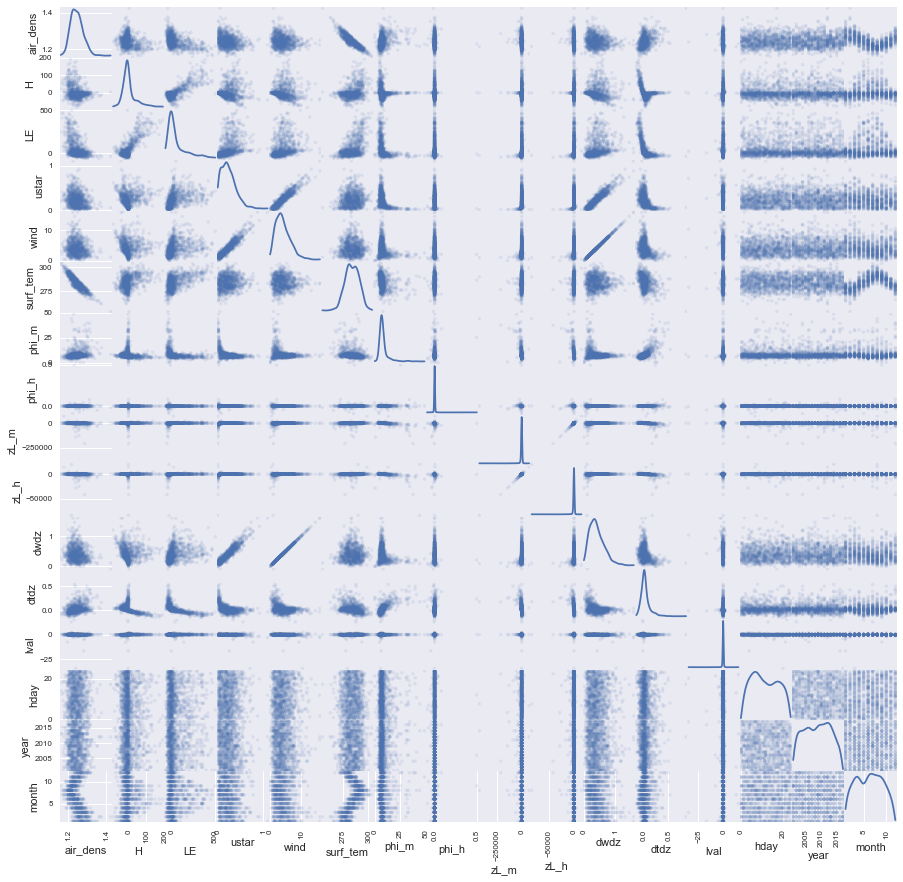

In [456]:
_ = pd.plotting.scatter_matrix(
    df.sample(1000)[measurement_cols + computed_cols + ['hday', 'year', 'month']],
    figsize=(15, 15), alpha=0.1, diagonal='kde'
)

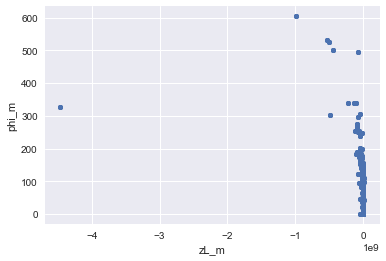

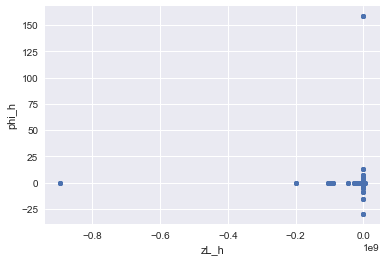

In [457]:
df.plot.scatter('zL_m', 'phi_m')
df.plot.scatter('zL_h', 'phi_h')

clearly something is wrong

the measurement of $u_*$ is very inaccurate at low values, when there's no turbulence. this causes very small values of L, leading to huge values of |z/L|

hogstrom 1988 only kept measures with $u_*>0.1$ and $\vert H\vert>10$

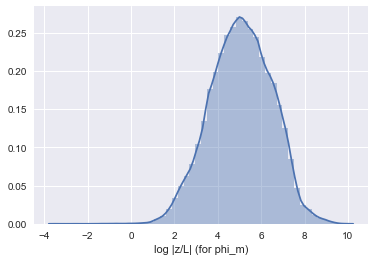

In [460]:
reliable_mask = (df.ustar > 0.1) & (abs(df.H) > 10)
sns.distplot(np.log(df[reliable_mask].zL_m.abs().dropna()))
plt.xlabel('log |z/L| (for phi_m)')
plt.show()

this isnt enough for our purposes, and there are other factors that make a large |z/L|.

TODO investigate more

we will still discard values outside these limits

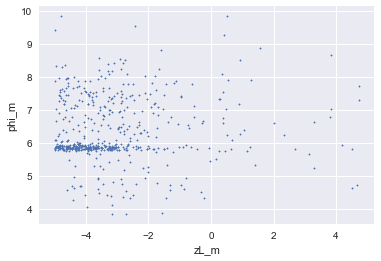

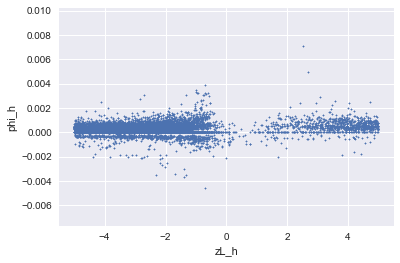

In [471]:
df[reliable_mask & (abs(df.zL_m) < 5)].plot.scatter('zL_m', 'phi_m', s=1)
df[reliable_mask & (abs(df.zL_h) < 5)].plot.scatter('zL_h', 'phi_h', s=1)

## Checking $\phi_m$

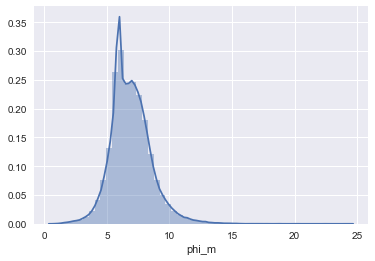

In [462]:
sns.distplot(df[reliable_mask].phi_m.dropna())
plt.xlabel('phi_m')
plt.show()

we can compare the CDF of the variables by creating groups based on the range of $\phi_m$. we select the interval (0, 1) because it (supposedly) contains values of phi_m for stable conditions

In [514]:
ints = [0, 1, 4, 10, 25]
print('interv.\tcount')
for low, high in zip(ints[:-1], ints[1:]):
    count = len(df[reliable_mask & (df.phi_m >= low) & (df.phi_m < high)])
    print('%d->%d\t%d' % (low, high, count))

interv.	count
0->1	36
1->4	12198
4->10	490254
10->25	20238


the distribution is _very_ suspicious, stable conditions should happen way more often

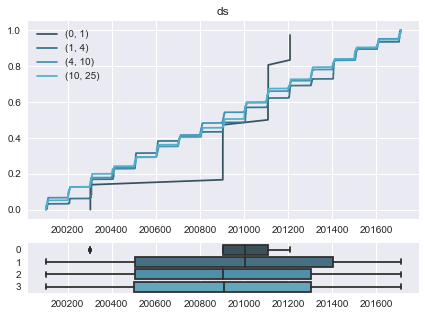

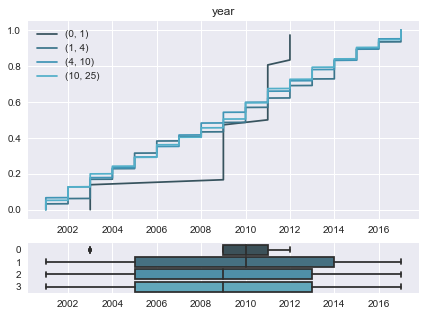

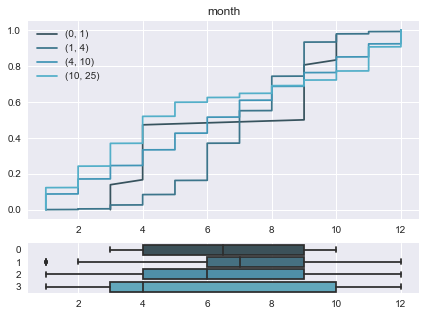

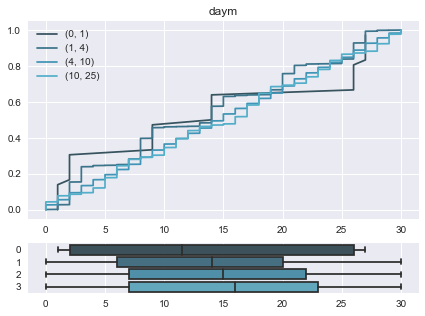

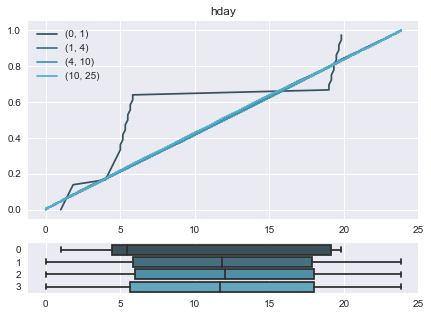

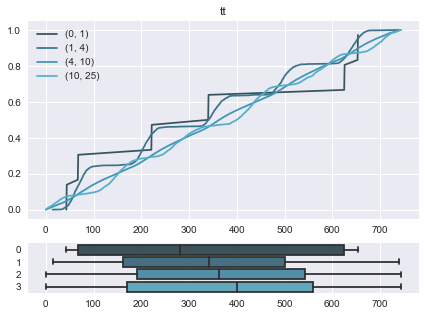

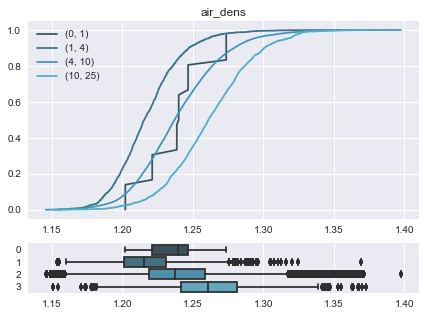

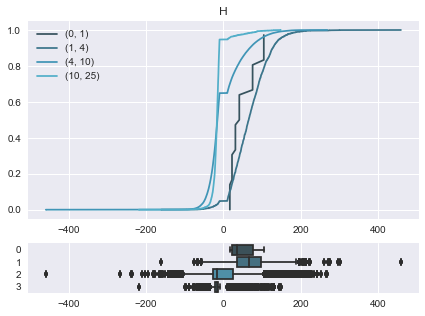

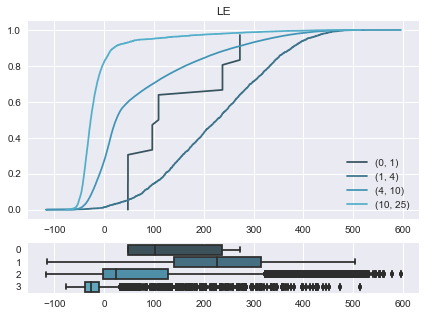

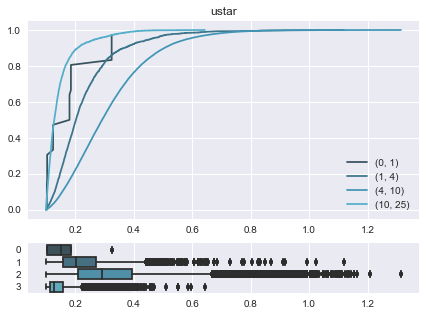

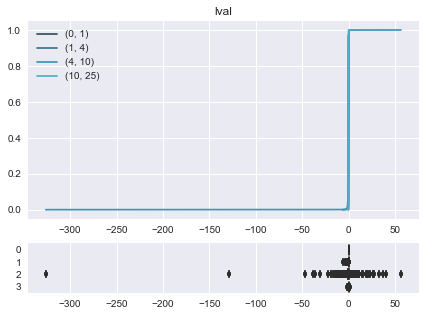

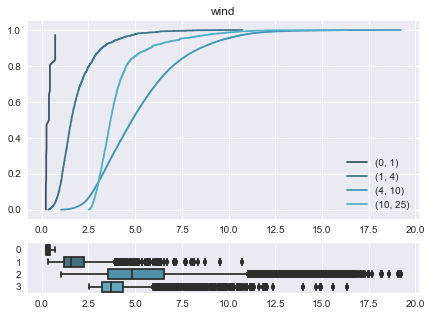

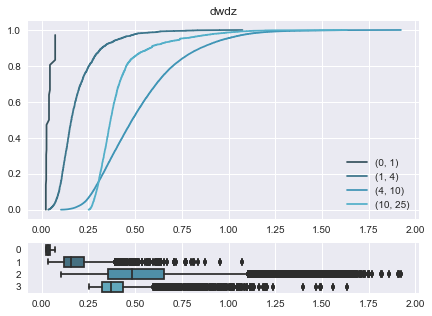

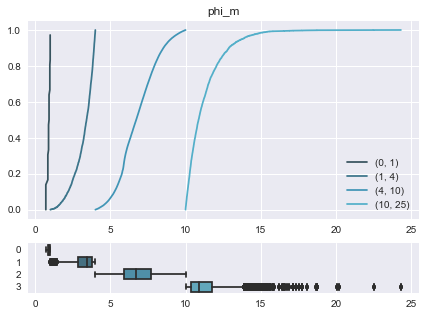

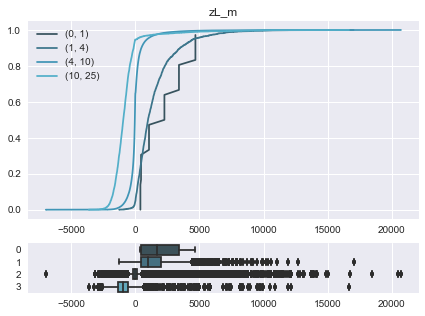

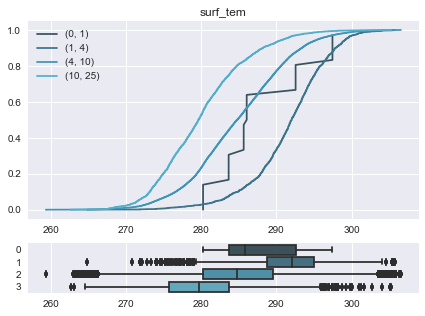

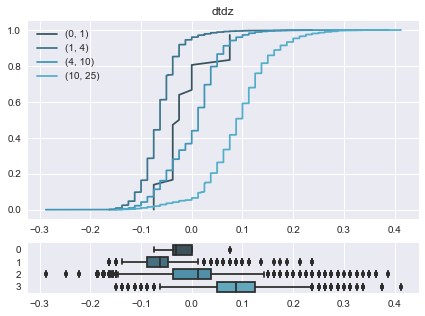

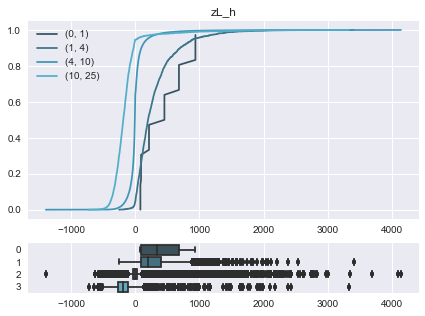

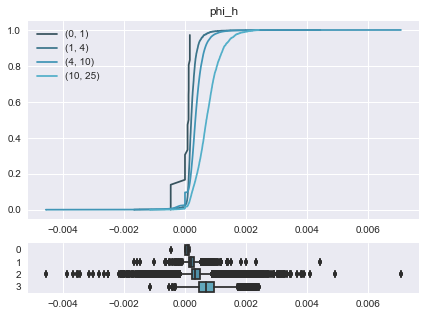

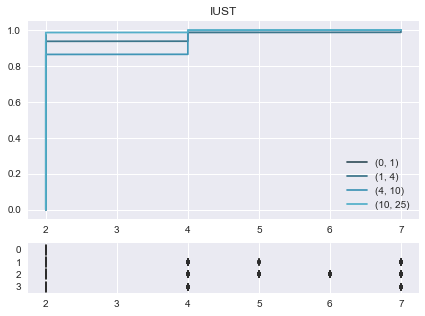

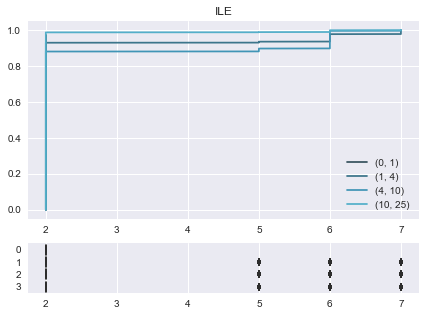

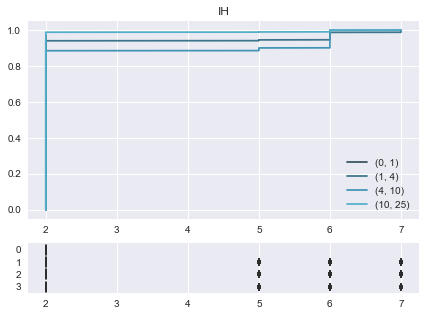

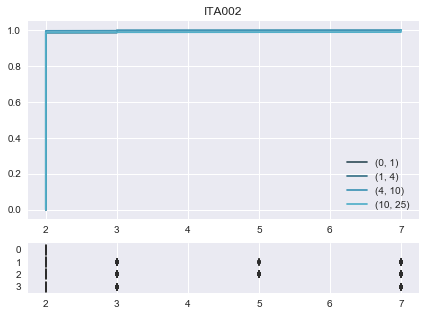

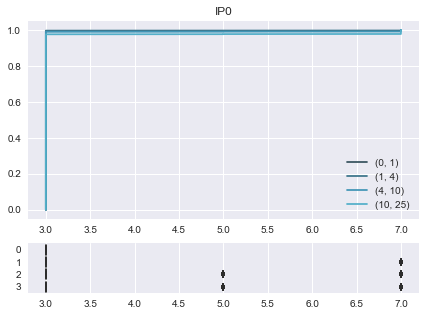

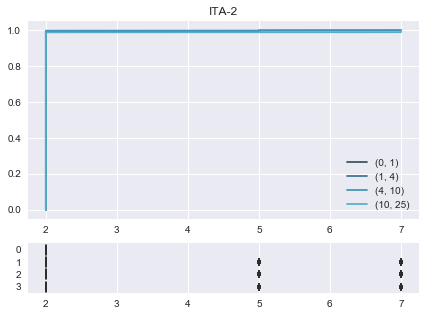

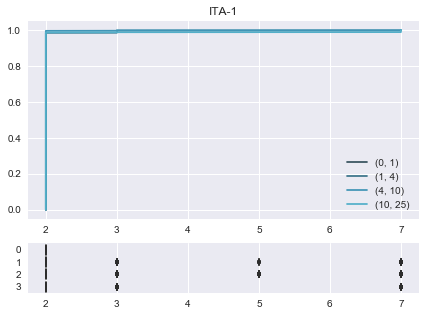

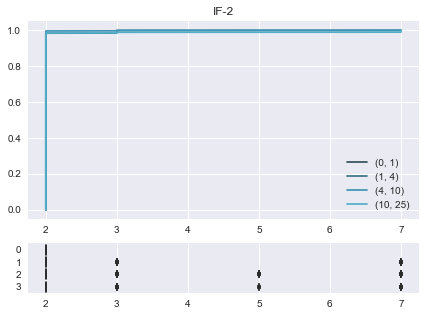

In [547]:
def plot_cdf(rvars, labels=None):
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax1 = plt.subplot(gs[0])

    for i, ss in enumerate(rvars):
        lbl = labels[i] if labels is not None else None

        ax1.plot(ss, np.arange(len(ss)) / len(ss), label=lbl)
    
    if labels is not None:
        ax1.legend()
    
    ax2 = plt.subplot(gs[1])
    sns.boxplot(data=rvars, ax=ax2, orient='h')

    return ax1, ax2


def inspect_col(colname, interval):
    vs = [
        df[colname][reliable_mask & (df.phi_m >= low) & (df.phi_m < high)].dropna().sort_values()
        for low, high in zip(interval[:-1], interval[1:])
    ]

    plt.figure(figsize=(7, 5))
    ax1, _ = plot_cdf(vs, list(map(str, zip(interval[:-1], interval[1:]))))
    ax1.set_title(colname)
    plt.show()
    

old_pal = sns.color_palette()
sns.set_palette('GnBu_d')

[inspect_col(col, ints) for col in df]

sns.set_palette(old_pal)

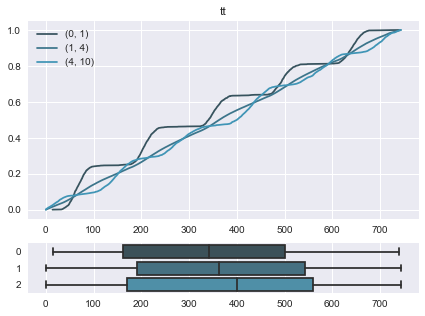

In [544]:
inspect_col('tt', [1, 4, 10, 25])

there is a huge difference between phi_m < 1 and phi_m >= 1

most importantly, phi_m < 1 happens in very specific intervals

TODO check cabauw documentation, wind readings are _extremely_ abnormal at those times

In [538]:
df[reliable_mask & (df.phi_m < 1)].groupby(('year', 'month', 'daym', 'hday')).size().sort_index()

year  month  daym  hday     
2003  3      9     5.000015     1
                   5.166672     1
                   5.333344     1
                   5.500015     1
                   5.666672     1
                   5.833344     1
2009  4      26    1.000061     1
                   1.166687     1
                   1.333374     1
                   1.500061     1
                   1.666687     1
                   1.833374     1
             27    5.000061     1
                   5.166687     1
                   5.333374     1
                   5.500061     1
                   5.666687     1
                   5.833374     1
2011  9      1     19.000004    1
                   19.166668    1
                   19.333336    1
                   19.500004    1
                   19.666668    1
                   19.833336    1
      10     2     19.000000    1
                   19.166672    1
                   19.333336    1
                   19.500000    1
                   

seems like the source of the data (I-columns) does not play a role in differentiating the phi levels

we see larger $\phi_m$s associated with denser air/colder surface temperature, more wind, higher friction velocity, and larger and mostly positive temperature gradient; this is consistent with what we would expect, as $\phi_m$ is expected to be higher in stable condtions

there seems to be a curious pattern in the time of the month when data with small and large phi values is obtained:

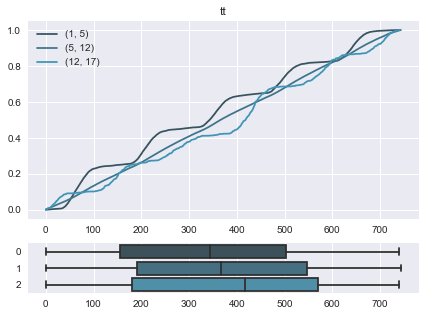

In [573]:
inspect_col('tt', [1, 5, 12, 17])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


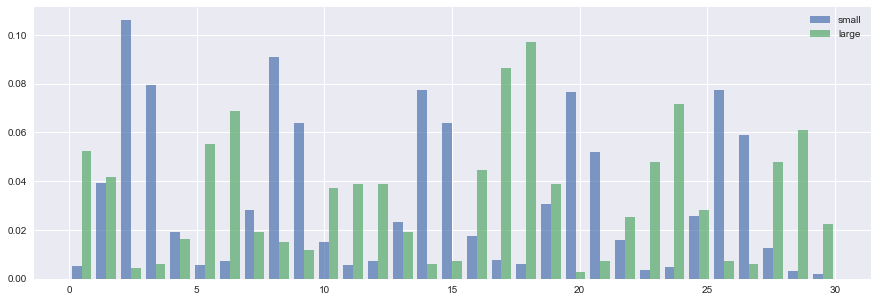

In [579]:
small_mask = reliable_mask & (df.phi_m > 1) & (df.phi_m < 5)
large_mask = reliable_mask & (df.phi_m > 12) & (df.phi_m < 17)

plt.figure(figsize=(15, 5))
plt.hist([df[small_mask].daym, df[large_mask].daym],
         stacked=False, bins=31, alpha=0.7, density=True,
         label=['small', 'large'])
plt.legend()
plt.show()

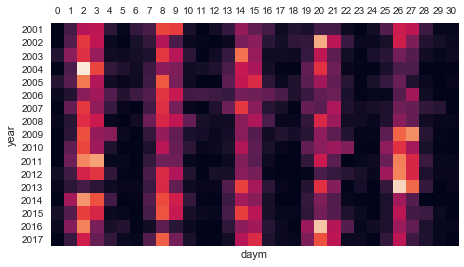

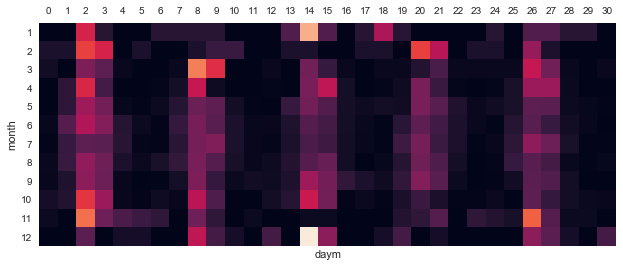

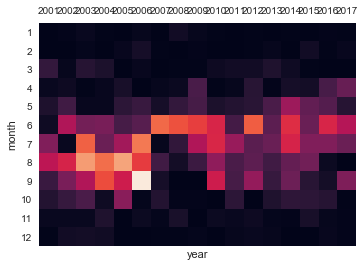

In [584]:
def matcount(row, col, transpose=False, norm=False):
    mat = (df[small_mask]
        .groupby(row)[col].value_counts()
        .rename('count').reset_index()
        .pivot(index=col, columns=row)
        .fillna(0).as_matrix())

    if norm:
         mat /= mat.sum(axis=0)
    
    if transpose:
        mat = mat.T
        row, col = col, row

    plt.matshow(mat)
    plt.xticks(range(len(df[row].unique())), sorted(df[row].unique()))
    plt.yticks(range(len(df[col].unique())), sorted(df[col].unique()))
    plt.xlabel(row)
    plt.ylabel(col)
    plt.grid(False)


matcount('year', 'daym', True, True) # normalize by year, transpose to plot horizontally
matcount('month', 'daym', True, True) # normalize by month, transpose to plot horizontally
matcount('year', 'month')

seems like the 6 days seasonality does not depend on the year nor on the month of the year, if we take into account the fact that some months have way more measures than others

what bothers me is that this 6 days cycle repeats more or less regularly for more than 15 years

In [585]:
from collections import defaultdict
csm = defaultdict(int)
clg = defaultdict(int)

for i, row in df.iterrows():
    dt = datetime.date(int(row.year), int(row.month), int(row.daym) + 1)
    if abs(row.phi_m) < 5:
        csm[dt.weekday()] += 1
    else:
        clg[dt.weekday()] += 1

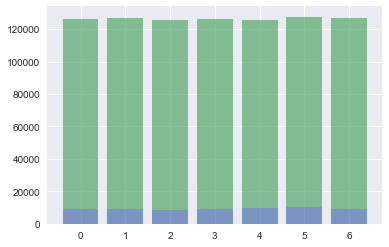

In [586]:
plt.bar(range(7), list(csm.values()), alpha=0.7)
plt.bar(range(7), list(clg.values()), bottom=list(csm.values()), alpha=0.7)
plt.show()

does not depend on day of week